# CD Legislative Changes - WIP

During the last decade, controlled drugs legislation has been amended on various occasions due to concerns. In tis notebook we will set out to examine the impact of reclassification on Prescribing Patterns

- [Gabapentinoids](#gaba)
- [Tramadol](#tramadol)
- [Zopiclone & Zaleplon](#zdrugs) ->NOT STARTED YET
- [Lisdexamfetamine](#lisdex) ->NOT STARTED YET
- [Overall Summary](#summ) -> NOT STARTED YET



In [34]:
#import libraries required for analysis
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from ebmdatalab import bq
import os

# Gabapentinoids <a id='gaba'></a>
In April 2019 Gabapentinoids (i.e. pregabaln and gabapentin) were reclassified under the misuse of drugs act. This followed the [Advisory Committee of Misuse of Drugs recommending reclassification due to their concerns](https://www.gov.uk/government/news/pregabalin-and-gabapentin-to-be-controlled-as-class-c-drugs) over rising prescribing, misuse and deaths associated with both medicines. The reclassification we intended to bring in stronger controls and reduce the chances of medicines being used inapprorpiately.

On OpenPrescribing we have various measures on gabapentinoid prescribing including including a measure of total use by using [Daily Defined Doses (DDD) to include both medicines in a single measure](https://openprescribing.net/measure/gabapentinoidsddd/).


In [35]:
sql1 = '''
SELECT
  month,
  pct_id,
  sum(numerator) as total_gaba,
FROM
  `ebmdatalab.measures.ccg_data_gabapentinoidsddd` AS p
GROUP BY
month,
pct_id
'''

df_gaba = bq.cached_read(sql1, csv_path=os.path.join('..', 'data', 'df_gaba.csv'))
df_gaba['month'] = pd.to_datetime(df_gaba['month'])
df_gaba.rename(columns={'pct_id':'pct'}, inplace=True) ##prep for maps library whe  pct must be colum name
df_gaba.head(5)




,month,pct,total_gaba
0,2020-04-01,07P,59784.327778
1,2020-03-01,07P,63836.238889
2,2019-11-01,07P,60419.316667
3,2019-07-01,07P,64346.488889
4,2018-03-01,07P,60850.283333


(0, 30000000)

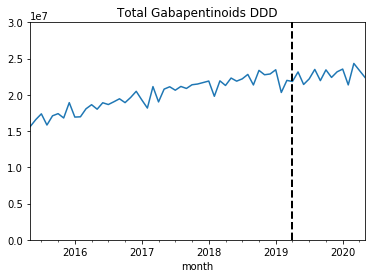

In [36]:
ax = df_gaba.groupby(["month"])['total_gaba'].sum().plot(kind='line', title="Total Gabapentinoids DDD")
ax.axvline(pd.to_datetime('2019-04-01'), color='black', linestyle='--', lw=2) ##law change
plt.ylim(0, 30000000 )

# Tramadol <a id='tramadol'></a>

In June 2014 tramdol was reclassified as a schedule 3 CD and the [ONS reported 5% drop in tramadol prescribing](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/bulletins/deathsrelatedtodrugpoisoninginenglandandwales/2015registrations) as well as the first fall in deaths related to tramadol since the first recorded death. The [Royal Pharmaceutical Society have a brefing here](https://www.rpharms.com/about-us/news/details/Rescheduling-of-gabapentin-and-pregabalin-to-Schedule-3-Controlled-Drugs-from-1-April-2019) (login required). OpenPrescribing item data goes back to 2011 but raw prescribing information only goes back to January 2014. We will do a two step analysis
1. Assess overall change in items and cost (indicative of qty) 

2. a) Work our total amounts of mg of tramadol dispensed in raw data for six months prior to the change. <br />
    b) Work out tablet quantities for the 50mg and 100mg

In [37]:
sql2 = '''
SELECT
  month,
  bnf_name,
  bnf_code,
  SUM(items) AS total_items,
  SUM(actual_cost) AS total_cost
FROM
  ebmdatalab.hscic.normalised_prescribing AS rx
WHERE
 bnf_code LIKE '040702040%'
GROUP BY
  month,
  bnf_name,
  bnf_code
ORDER BY
  month
'''

df_tramadol = bq.cached_read(sql2, csv_path=os.path.join('..', 'data', 'df_tramadol.csv'))
df_tramadol['month'] = pd.to_datetime(df_tramadol['month'])
df_tramadol.head(5)

,month,bnf_name,bnf_code,total_items,total_cost
0,2010-08-01 00:00:00+00:00,Tramacet_Tab 37.5mg/325mg,040702040BFAAAU,6741,93751.57
1,2010-08-01 00:00:00+00:00,Tramulief SR_Tab 150mg,040702040BKABAD,11,141.20
2,2010-08-01 00:00:00+00:00,Tramadol HCl_Orodisper Tab 50mg,040702040AAATAT,775,7404.95
3,2010-08-01 00:00:00+00:00,Tramadol/Paracet_Tab Eff 37.5/325mg S/F,040702040AABABA,171,1881.57
4,2010-08-01 00:00:00+00:00,Dromadol SR_Tab 100mg,040702040BEABAC,20,251.99


(0, 800000)

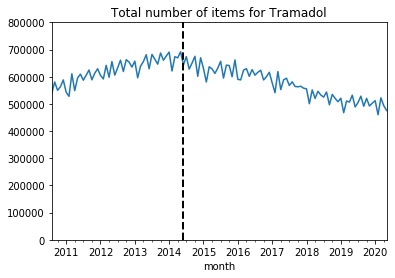

In [38]:
ax = df_tramadol.groupby(["month"])['total_items'].sum().plot(kind='line', title="Total number of items for Tramadol")
ax.axvline(pd.to_datetime('2014-06-01'), color='black', linestyle='--', lw=2) ##law change
plt.ylim(0, 800000)

(0, 4597263.389132996)

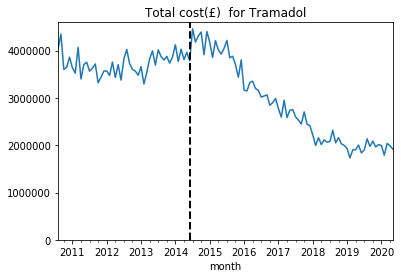

In [39]:
ax = df_tramadol.groupby(["month"])['total_cost'].sum().plot(kind='line', title="Total cost(£)  for Tramadol")
ax.axvline(pd.to_datetime('2014-06-01'), color='black', linestyle='--', lw=2) ##law change
plt.ylim(0, )

In [40]:
#for prototype I'll just take a look at 50mg caps
sql3 = '''
SELECT
  month,
  bnf_name,
  bnf_code,
SUM(CASE
      WHEN SUBSTR(bnf_code,14,2)='AA' THEN quantity * 50 #Tramadol 50mg capsules
      WHEN SUBSTR(bnf_code,14,2)='AT' THEN quantity * 50 #Tramadol 50mg orodispersible tablets sugar free
      WHEN SUBSTR(bnf_code,14,2)='AG' THEN quantity * 50 #Tramadol 50mg modified-release capsules
      WHEN SUBSTR(bnf_code,14,2)='AY' THEN quantity * 50 #Tramadol 50mg modified-release tablets
      WHEN SUBSTR(bnf_code,14,2)='AF' THEN quantity * 50 #Tramadol 50mg soluble tablets sugar free
      ELSE 0 END) AS tramadol_mg
FROM
  ebmdatalab.hscic.normalised_prescribing
WHERE
 bnf_code LIKE '040702040%'
GROUP BY
  month,
  bnf_name,
  bnf_code
ORDER BY
  month
'''

df_raw_tramadol = bq.cached_read(sql3, csv_path=os.path.join('..', 'data', 'df_tramadol_raw.csv'))
df_raw_tramadol['month'] = pd.to_datetime(df_raw_tramadol['month'])
df_raw_tramadol.head(5)

Downloading: 100%|██████████| 9228/9228 [00:00<00:00, 12001.14rows/s]


,month,bnf_name,bnf_code,tramadol_mg
0,2010-08-01 00:00:00+00:00,Tradorec XL_Tab 200mg,040702040BIABAE,0.0
1,2010-08-01 00:00:00+00:00,Mabron_Tab 200mg M/R (Morningside),040702040BHACAE,0.0
2,2010-08-01 00:00:00+00:00,Marol_Tab 100mg M/R,040702040BNAAAC,0.0
3,2010-08-01 00:00:00+00:00,Tramacet_Tab Eff 37.5mg/325mg,040702040BFABBA,0.0
4,2010-08-01 00:00:00+00:00,Maxitram SR_Cap 100mg,040702040BPABAH,0.0


(0, 3500000000)

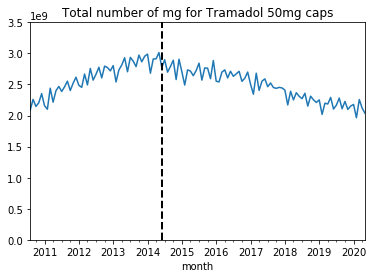

In [41]:
ax = df_raw_tramadol.groupby(["month"])['tramadol_mg'].sum().plot(kind='line', title="Total number of mg for Tramadol 50mg caps")
ax.axvline(pd.to_datetime('2014-06-01'), color='black', linestyle='--', lw=2) ##law change
plt.ylim(0, 3500000000 )

# Z-Drugs <a id='zdrugs'></a>

Here the change is about reducing the amount on prescription at any one time. WE should look at decreases as well as a measure of 28/30 day scripts.

•	https://www.rpharms.com/about-us/news/details/Controlled-drug-changes--tramadol--lisdexamfetamine--zopiclone-and-zaleplon



In [42]:
sql4 = '''
WITH
bnf_tab AS (
SELECT
DISTINCT chemical,
chemical_code
FROM
ebmdatalab.hscic.bnf )
SELECT
  month,
  chemical,
  SUM(items) AS total_items,
  SUM(actual_cost) AS total_cost
FROM
  ebmdatalab.hscic.normalised_prescribing AS rx
LEFT JOIN
bnf_tab
ON
chemical_code =SUBSTR(rx.bnf_code,1,9)
WHERE
 bnf_code LIKE '0401010W0%' OR #zaleplon
 bnf_code LIKE '0401010Z0%'    #zopiclone
GROUP BY
  month,
  chemical
ORDER BY
  month
'''

df_z_drugs = bq.cached_read(sql4, csv_path=os.path.join('..', 'data', 'df_z_drugs.csv'))
df_z_drugs['month'] = pd.to_datetime(df_z_drugs['month'])
df_z_drugs.head(5)

,month,chemical,total_items,total_cost
0,2010-08-01 00:00:00+00:00,Zopiclone,421868,647624.49
1,2010-08-01 00:00:00+00:00,Zaleplon,248,1090.55
2,2010-09-01 00:00:00+00:00,Zopiclone,451915,689550.55
3,2010-09-01 00:00:00+00:00,Zaleplon,228,1004.73
4,2010-10-01 00:00:00+00:00,Zopiclone,430882,552587.48


In [43]:
df_zopi = df_z_drugs.loc[df_z_drugs["chemical"] == "Zopiclone"]

In [44]:
df_zap = df_z_drugs.loc[df_z_drugs["chemical"] == "Zaleplon"]

(0, 371.65)

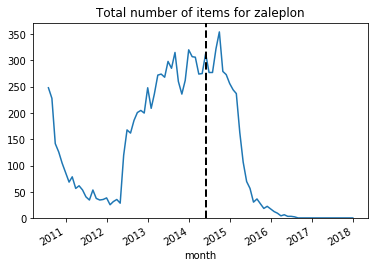

In [45]:
ax = df_zap.groupby(["month"])['total_items'].sum().plot(kind='line', title="Total number of items for zaleplon")
ax.axvline(pd.to_datetime('2014-06-01'), color='black', linestyle='--', lw=2) ##law change
plt.ylim(0, )

(0, 600000)

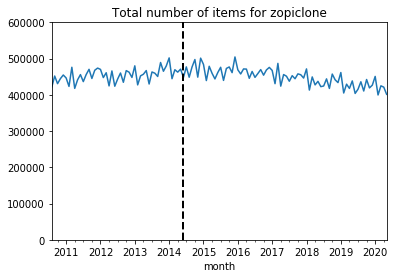

In [46]:
ax = df_zopi.groupby(["month"])['total_items'].sum().plot(kind='line', title="Total number of items for zopiclone")
ax.axvline(pd.to_datetime('2014-06-01'), color='black', linestyle='--', lw=2) ##law change
plt.ylim(0, 600000 )

In [ ]:
#next we'll just look at zopiclone to see affect on qty and total dose dispensed.



# Lisedexamfetamine <a id='lisdex'></a>

# Overall Summary <a id='summ'></a>